# Building The Model

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
import arviz as az
import jax.numpy as jnp

In [40]:
rng_key = random.key(0)

In [4]:
DATA_PATH = "../data/948363589_T_ONTIME_MARKETING.zip"
df = pd.read_csv(DATA_PATH)

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_2044\2726963897.py:2: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


As an example, below is a plot of the distribution of arrival delays arriving at `MSN` airport from `MSP`

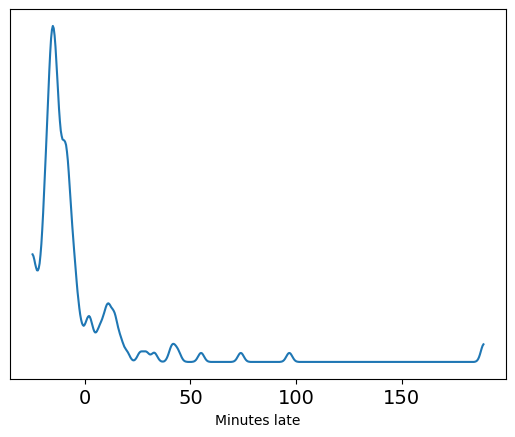

In [7]:
fig, ax = plt.subplots()

msn_arrivals = df[(df["DEST"] == "MSN") & df["ORIGIN"].isin(["MSP"])]["ARR_DELAY"]

az.plot_kde(msn_arrivals.values, ax=ax)
ax.set_yticks([])
ax.set_xlabel("Minutes late");

We can see that the delay is continous variable that is skewed. We have a few distributions that we could use:

1. Normal: it is symmetrical and inconsistent with the observed skewness
2. Skew-Normal
3. Gumbel: it is used to model the distribution of the maximum (or the minimum) of a number of samples

We will compare the Normal and Gumbel distributions

## Choosing Priors

Let's plot the distribution of delays

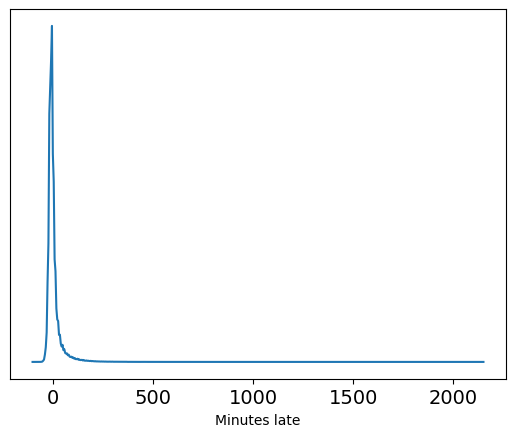

In [32]:
fig, ax = plt.subplots()

az.plot_kde(df['ARR_DELAY'].values, ax=ax)
ax.set_yticks([])
ax.set_xlabel("Minutes late");

let's exclude extreme values to see the distribution more clearly

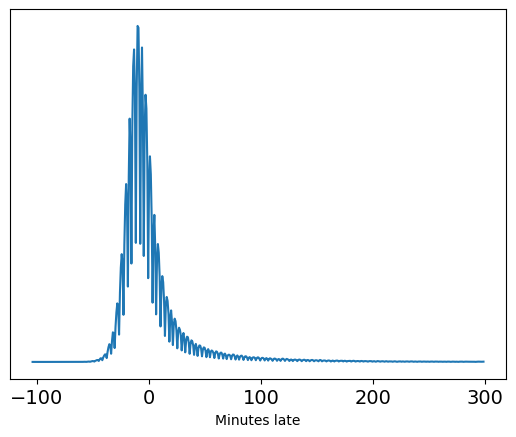

In [34]:
fig, ax = plt.subplots()

delays = df['ARR_DELAY'][df['ARR_DELAY'] < 300]
az.plot_kde(delays.values, ax=ax)
ax.set_yticks([])
ax.set_xlabel("Minutes late");

We can see that flight arrivals can be early or late (negative or positive respectively) but exhibit some bounds. It is unlikely that a flight would arrive more than 3 hours late, be more than 3 hours early.

Based on that we can can set priors for $\mu$ and scale. 

We choose the normal distrubtion for the \mu centered at zero with standard deviation of 40 (delay can by 0 $\pm$ 120) and the scale to follow a Half-StudentT distribution 


**Model 1**:

$$
\begin{aligned}
\mu &\sim \mathcal{N}(\mu=0, \sigma=40) \\
\sigma &\sim \mathcal{HT}(\nu=5, \mu=0, \sigma=60)\\
y &\sim \mathcal{N}(\mu, \sigma)
\end{aligned}
$$

**Model 2**:

$$
\begin{aligned}
\mu &\sim \mathcal{N}(\mu=0, \sigma=40) \\
\beta &\sim \mathcal{HT}(\nu=5, \mu=0, \sigma=60)\\
y &\sim \text{Gumbel}(\mu, \beta)\\
\end{aligned}
$$

let's simulate some data to see if our priors are reasonable

In [82]:
class HalfStudentT(dist.Distribution):
    from jax import lax
    arg_constraints = {
        "df": dist.constraints.positive,
        "scale": dist.constraints.positive,
    }
    support = dist.constraints.real
    reparametrized_params = ["df", "scale"]
    pytree_data_fields = ("df", "scale", "_chi2")

    def __init__(self, df, scale=1.0, *, validate_args=None):
        self._studentT = dist.StudentT(df, 0.0, scale)
        batch_shape = lax.broadcast_shapes(
            jnp.shape(df), jnp.shape(scale)
        )
        self.df, self.scale = numpyro.distributions.util.promote_shapes(
            df, scale, shape=batch_shape
        )
        df = jnp.broadcast_to(df, batch_shape)
        self._chi2 = dist.Chi2(df)
        super(HalfStudentT, self).__init__(batch_shape, validate_args=validate_args)

    def sample(self, key, sample_shape=()):
        return jnp.abs(self._studentT.sample(key, sample_shape))

    def log_prob(self, value):
        return self._studentT.log_prob(value) + jnp.log(2)

    def cdf(self, value):
        return self._studentT.cdf(value) * 2 - 1

    def icdf(self, q):
        return self._studentT.icdf((q + 1) / 2)

In [88]:
def model1(delay_obs=None):
    mu = numpyro.sample("mu", dist.Normal(0, 40))
    sigma = numpyro.sample("sigma", HalfStudentT(5, 60))
    numpyro.sample("delay", dist.Normal(mu, sigma), obs=delay_obs)

In [89]:
def model2(delay_obs=None):
    mu = numpyro.sample("mu", dist.Normal(0, 40))
    beta = numpyro.sample("beta", HalfStudentT(5, 60))
    numpyro.sample("delay", dist.Gumbel(mu, beta), obs=delay_obs)

In [86]:
def sample(model, rng_key_):
    kernel = NUTS(model)
    sampler = MCMC(kernel, num_chains=4, num_warmup=500, num_samples=1000)
    sampler.run(rng_key_)
    return az.from_numpyro(sampler)

In [90]:
rng_key, rng_key_ = random.split(rng_key)
inf_data_model1 = sample(model1, rng_key_)

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_2044\2406517587.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(kernel, num_chains=4, num_warmup=500, num_samples=1000)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 3457.92it/s, 1 steps of size 2.34e-01. acc. prob=0.55]


In [91]:
rng_key, rng_key_ = random.split(rng_key)
inf_data_model2 = sample(model2, rng_key_)

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_2044\2406517587.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(kernel, num_chains=4, num_warmup=500, num_samples=1000)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 3206.58it/s, 7 steps of size 8.74e-02. acc. prob=0.69]


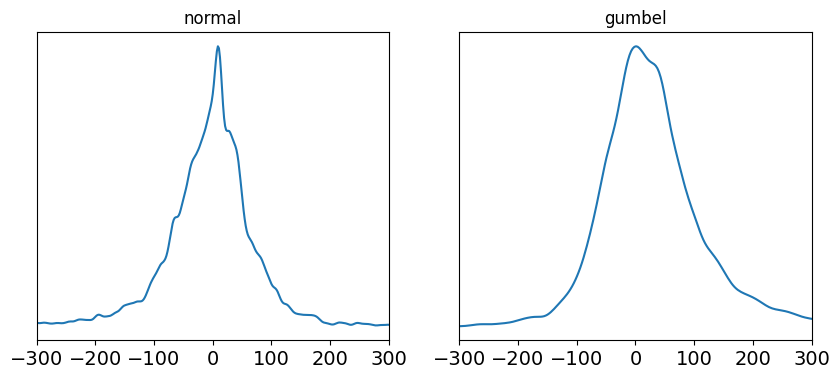

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

prior_predictives = {"normal": inf_data_model1.posterior['delay'].data, "gumbel": inf_data_model2.posterior['delay'].data }

for i, (label, prior_predictive) in enumerate(prior_predictives.items()):
    
    data = prior_predictive.flatten()
    az.plot_dist(data, ax=axes[i])
    axes[i].set_yticks([])
    axes[i].set_xlim(-300, 300)
    axes[i].set_title(label)